In [113]:
%matplotlib widget

import wave
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as signal
from scipy.fft import fftshift

### Summary

This book loads in a WAV file, will plot the channel time data and spectra. It then plots spectrograms for each channel.

The plots are interactive - viewing them in a booklet will allow one to zoom in and play around with the data

In [122]:


# Replace 'your_file_path.wav' with the path to your WAV file
file_path = 'D:\Recordings_All\PoolTests\Audio_fs_44100_Chans_4_1704206629_2000.wav'
 
# Separate channels into individual arrays
channel_data = []
sample_rate = -1
num_channels= -1

# Open the WAV file
with wave.open(file_path, 'rb') as wav_file:
    num_channels = wav_file.getnchannels()
    sample_width = wav_file.getsampwidth()
    num_frames = wav_file.getnframes()
    frame_rate = wav_file.getframerate()
    sample_rate = wav_file.getframerate()

    # Read audio frames from the WAV file
    frames = wav_file.readframes(num_frames)

    # Convert the binary data to a NumPy array
    audio_data = np.frombuffer(frames, dtype=np.int16)
   
    for i in range(num_channels):
        channel = audio_data[i::num_channels]
        channel_data.append(channel)


print("Channel count (n): " + str(num_channels))
print("Sample rate (Hz): " + str(sample_rate))
print("Recording length (s): " + str(len(channel_data[0])* 1/sample_rate))

Channel count (n): 4
Sample rate (Hz): 44100
Recording length (s): 30.00018140589569


### Time and Freq Plot

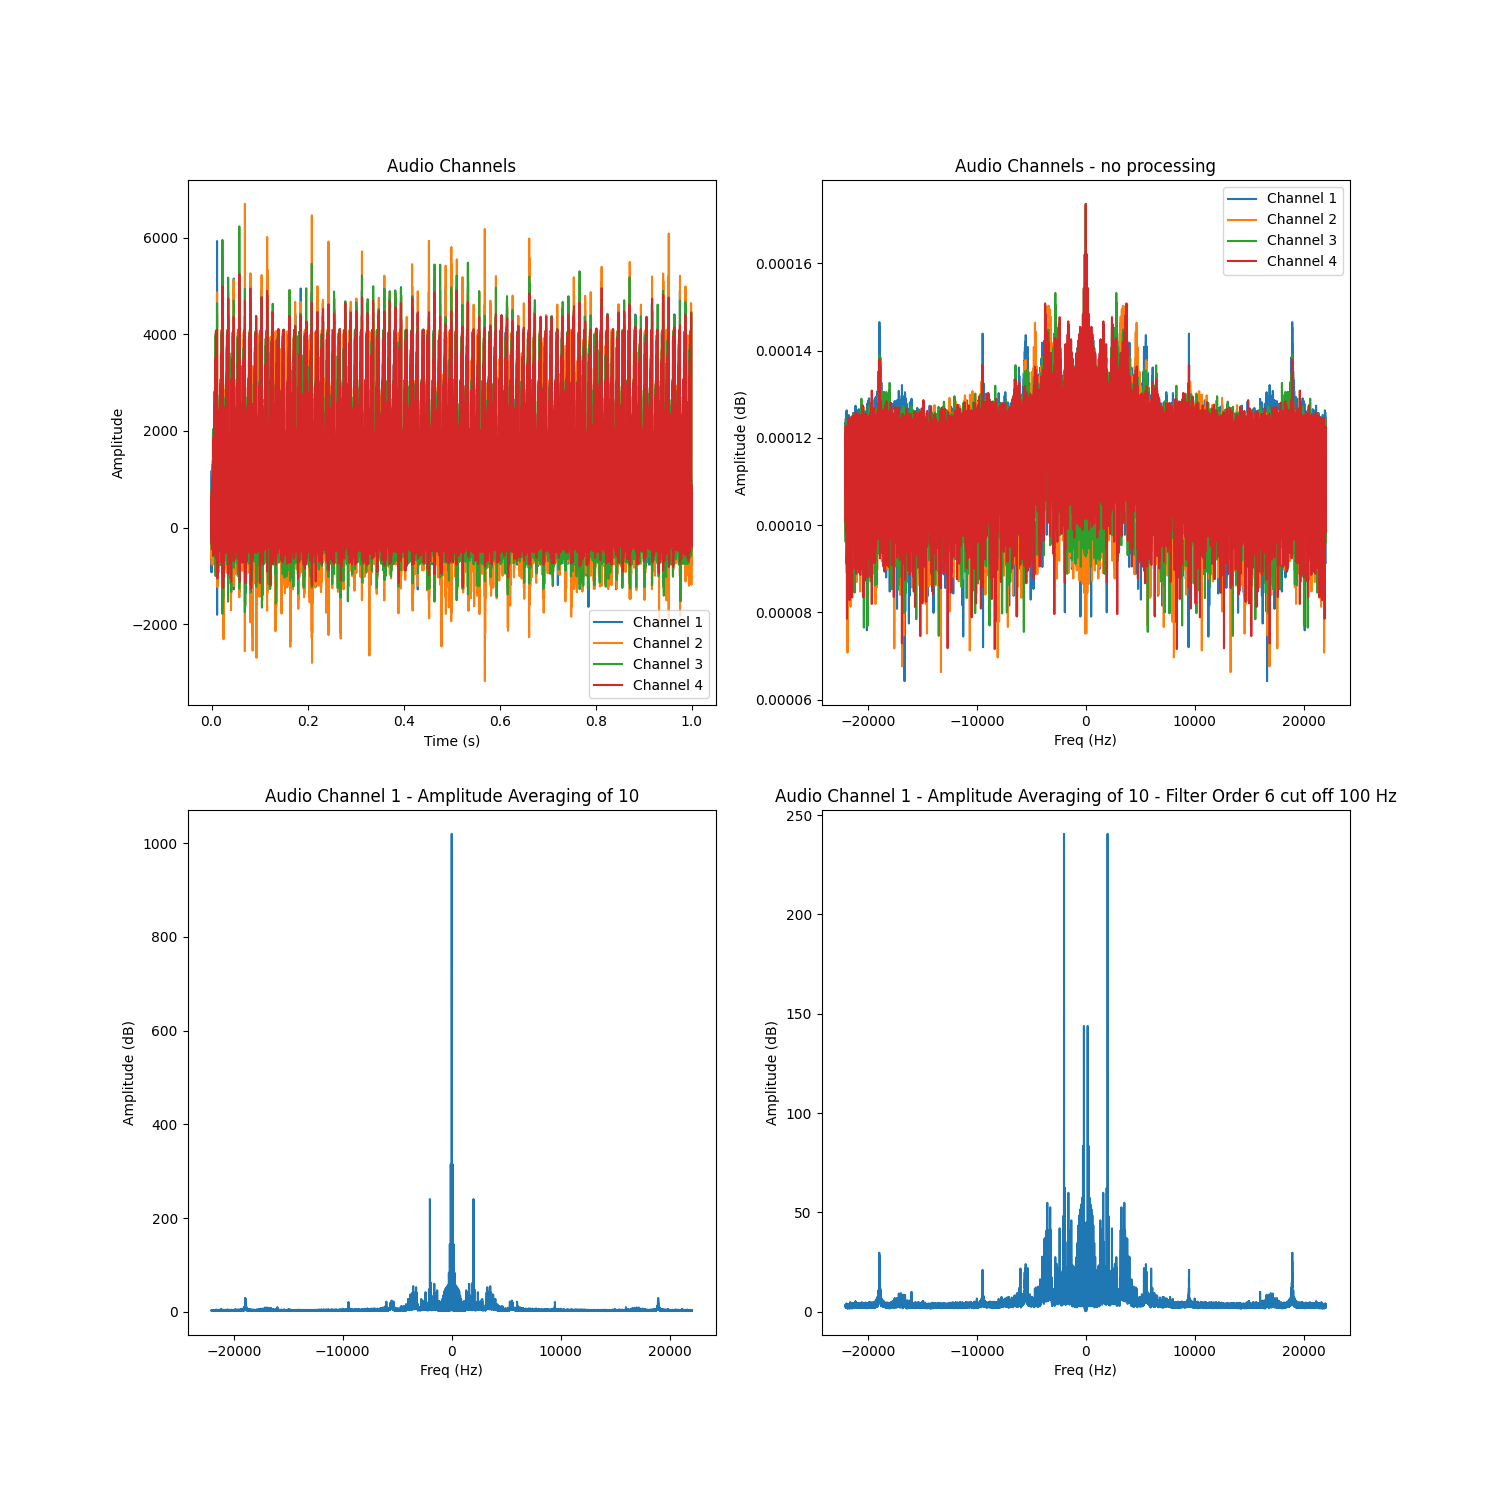

In [151]:
# Plot each channel
period_to_plot = 1 # seconds
averaging_count = 10
channel_of_interest = 0
sample_count = int(period_to_plot*sample_rate)

# Turn on interactive mode
if True:

    plt.ion()
    # Create a figure and plot each channel

    fig, ax = plt.subplots(2,2, figsize=(15, 15))
    time_axis = np.linspace(0,1,sample_count)

    for i, channel in enumerate(channel_data):
        ax[0,0].plot(time_axis, channel[:sample_count], label=f'Channel {i + 1}')

    ax[0,0].set_xlabel('Time (s)')
    ax[0,0].set_ylabel('Amplitude')
    ax[0,0].set_title('Audio Channels')
    ax[0,0].legend()

    for i, channel in enumerate(channel_data):
        fft_data_db = np.log10(np.abs(np.fft.fftshift(np.fft.fft(channel[:sample_count]))))/sample_count
        freq_axis = np.linspace(0,sample_count,sample_count)* (sample_rate/sample_count) - sample_rate/2
        ax[0,1].plot(freq_axis, fft_data_db, label=f'Channel {i + 1}')

    ax[0,1].set_xlabel('Freq (Hz)')
    ax[0,1].ticklabel_format(useOffset=False)
    ax[0,1].set_ylabel('Amplitude (dB)')
    ax[0,1].set_title('Audio Channels - no processing')
    ax[0,1].legend()

    averaged_fft_data = np.zeros((sample_count))
    for i in range(averaging_count):
        fft_data_tmp = (np.abs(np.fft.fftshift(np.fft.fft(channel_data[channel_of_interest][i*sample_count:(i+1)*sample_count]))))/sample_count
        averaged_fft_data += fft_data_tmp
    averaged_fft_data = averaged_fft_data/averaging_count   

    ax[1,0].plot(freq_axis,averaged_fft_data)
    ax[1,0].set_title(f'Audio Channel {channel_of_interest + 1} - Amplitude Averaging of {averaging_count}')
    ax[1,0].set_xlabel('Freq (Hz)')
    ax[1,0].set_ylabel('Amplitude (dB)')

    # Create a low-pass Butterworth filter
    cutoff_frequency = 100  # Adjust this cutoff frequency as needed (Hz)
    order = 6  # Filter order
    nyquist = 0.5 * sample_rate  # Nyquist frequency for a signal sampled at sample_rate
    normalized_cutoff = cutoff_frequency / nyquist
    b, a = signal.butter(order, normalized_cutoff, btype='high')
    filtered_signal = signal.filtfilt(b, a, channel_data[channel_of_interest])
        
    averaged_fft_data = np.zeros((sample_count))
    for i in range(averaging_count):
        fft_data_tmp = (np.abs(np.fft.fftshift(np.fft.fft(filtered_signal[i*sample_count:(i+1)*sample_count]))))/sample_count
        averaged_fft_data += fft_data_tmp
    averaged_fft_data = averaged_fft_data/averaging_count   

    ax[1,1].plot(freq_axis,averaged_fft_data)
    ax[1,1].set_title(f'Audio Channel {channel_of_interest + 1} - Amplitude Averaging of {averaging_count} - Filter Order {order} cut off {cutoff_frequency} Hz')
    ax[1,1].set_xlabel('Freq (Hz)')
    ax[1,1].set_ylabel('Amplitude (dB)')


    plt.show()


### Spectrogram Plot

#### Amplitude Data

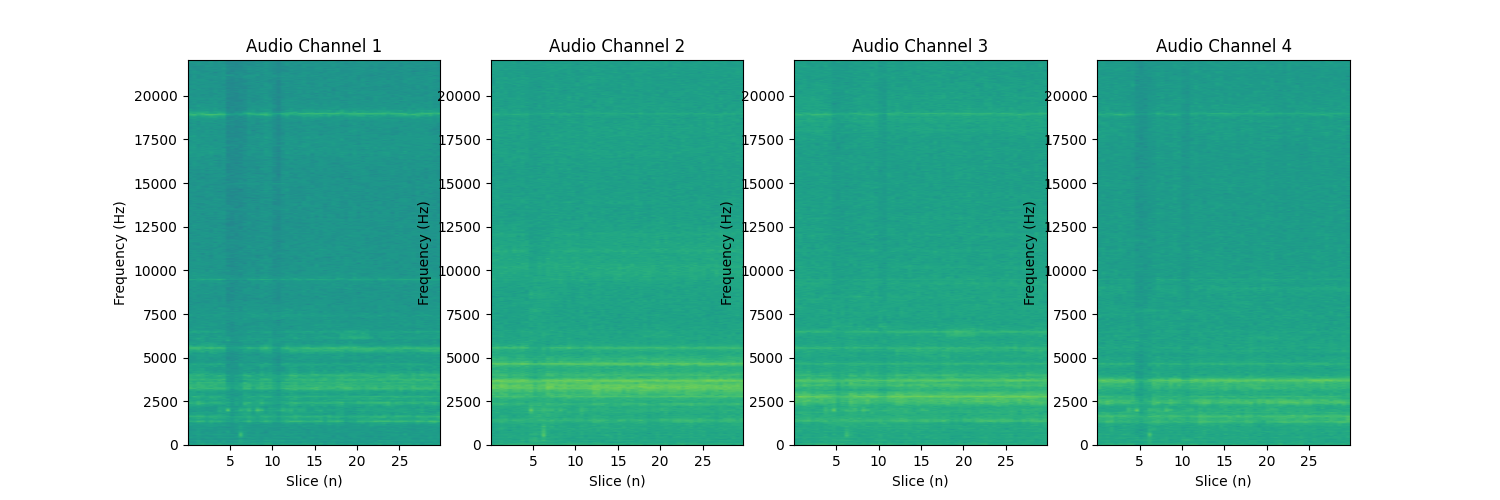

In [134]:
if True:
    
    plt.ion()
    fig1, ax = plt.subplots(1,num_channels, figsize=(15, 5))

    for i, channel in enumerate(channel_data):
        ax[i].specgram(channel,Fs=sample_rate,NFFT=22050)
        ax[i].set_ylabel('Frequency (Hz)')
        ax[i].set_xlabel('Slice (n)')
        ax[i].set_title(f'Audio Channel {i + 1}')

    plt.show()

#### Channel Phase Analysis

Differential phase between channel 1 and 2

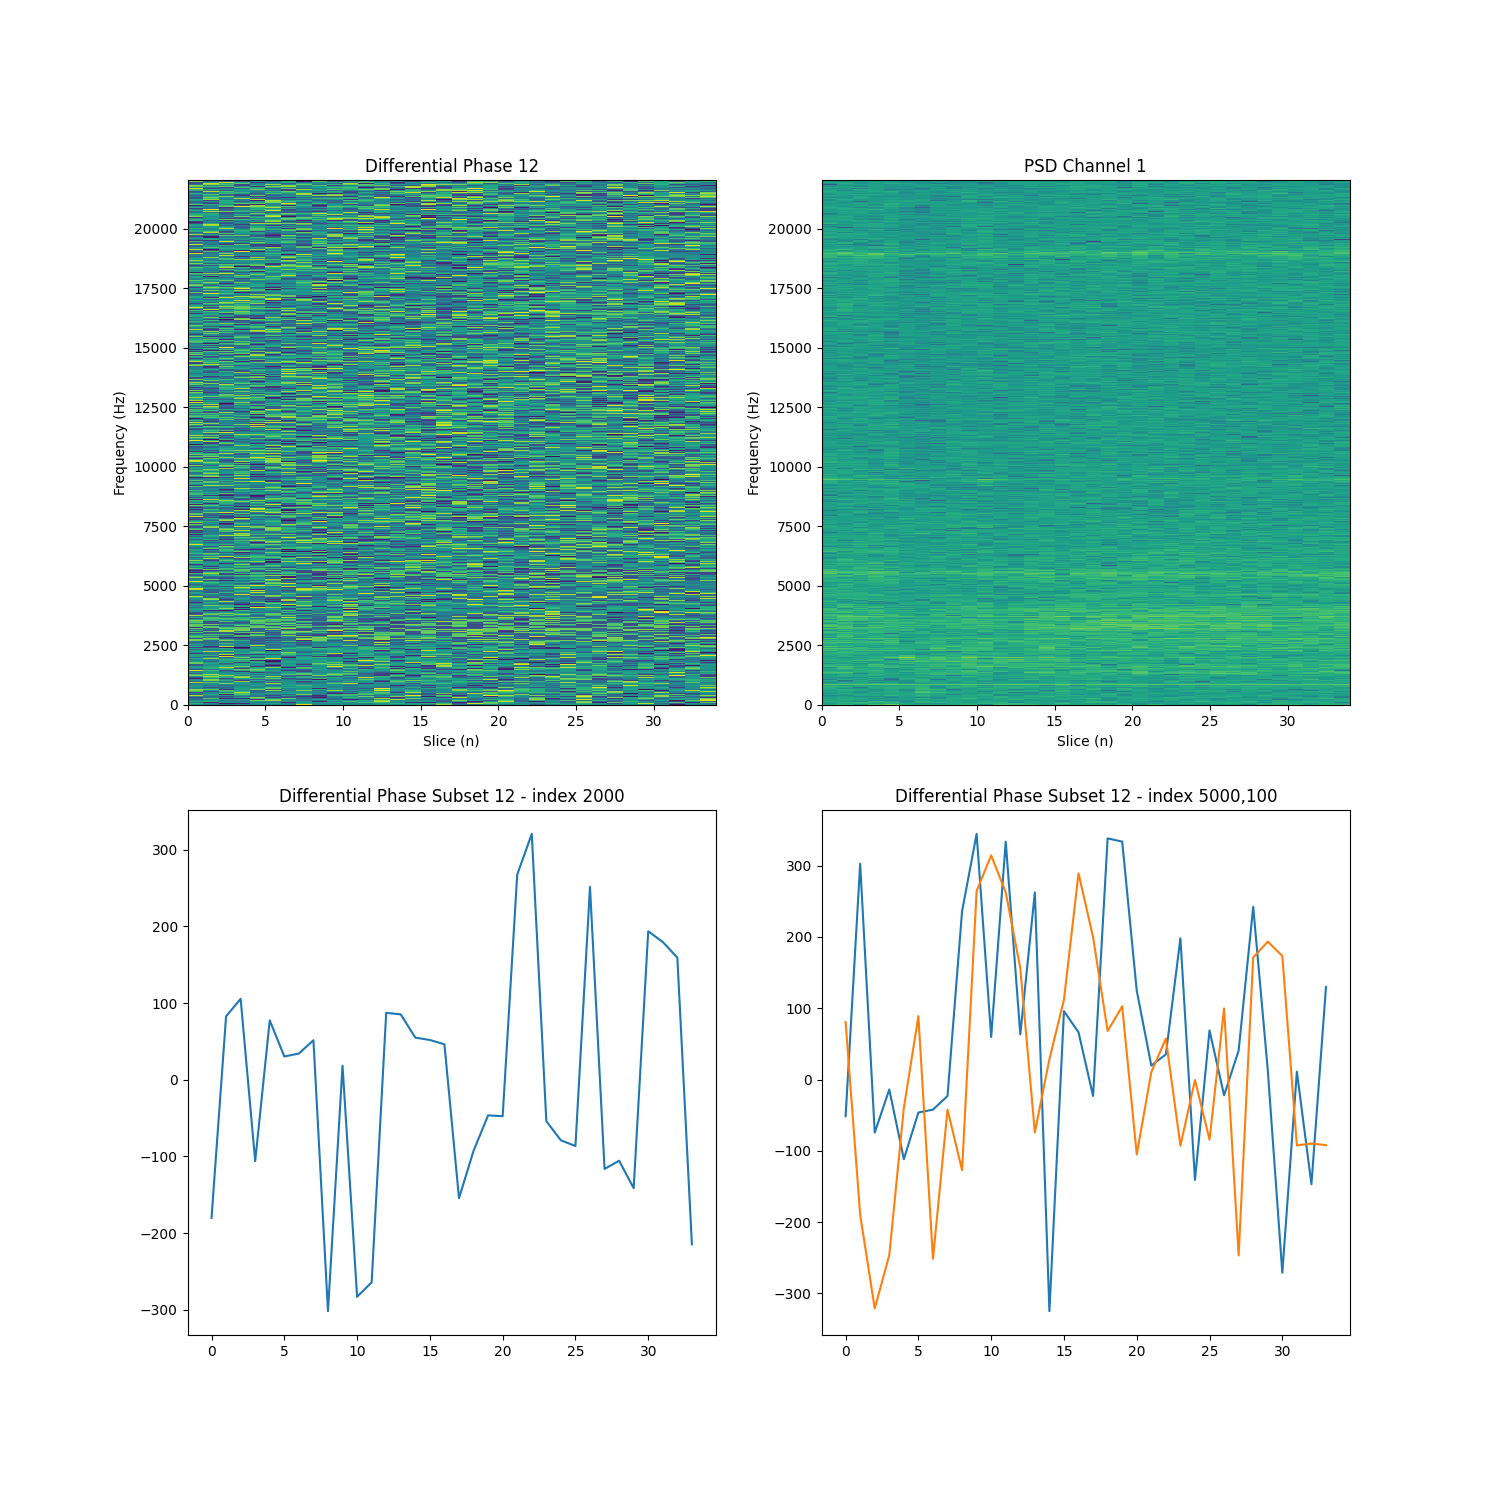

In [158]:
if True:
    
    plt.clf()
    plt.ion()
    fig, ax = plt.subplots(2,2, figsize=(15, 15))

    # Calculate the spectrogram for both channels
    f, t, Sxx1 = signal.spectrogram(channel_data[0], fs=sample_rate,  nperseg=44100, noverlap=5525)
    f, t, Axx1 = signal.spectrogram(channel_data[0], fs=sample_rate, nperseg=44100,mode='angle',noverlap=5525)
    f, t, Axx2 = signal.spectrogram(channel_data[1], fs=sample_rate, nperseg=44100,mode='angle',noverlap=5525)

    ax[0,0].pcolormesh(Axx1-Axx2)
    ax[0,0].set_title('Differential Phase 12')
    ax[0,0].set_xlabel('Slice (n)')
    ax[0,0].set_ylabel('Frequency (Hz)')

    ax[0,1].pcolormesh(20*np.log10(Sxx1))
    ax[0,1].set_title('PSD Channel 1')
    ax[0,1].set_xlabel('Slice (n)')
    ax[0,1].set_ylabel('Frequency (Hz)')

    ax[1,0].plot(np.squeeze((Axx1-Axx2)[2000,:])*180/np.pi) 
    ax[1,0].set_title(f'Differential Phase Subset 12 - Index {2000}')  
    

    ax[1,1].plot(np.squeeze((Axx1-Axx2)[5000,:])*180/np.pi) 
    ax[1,1].plot(np.squeeze((Axx1-Axx2)[100,:])*180/np.pi) 
    ax[1,1].set_title(f'Differential Phase Subset 12 - Index {5000},{100}')

    plt.show()